## Dataset Lenght of Stay

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

È interessante osservare la distribuzione dei diversi attributi.
Un fatto immediatamente evidente è lo sbilanciamento delle etichette di classe: la maggior parte delle durate di ricovero sono inferiori alla metà del valore massimo.

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split   #funzioni per dividere il dataset in test/validation/training set
import datetime #fornisce funzioni e classi per lavorare con date e tempi
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator #strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook
import base64 #fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
pd.set_option('future.no_silent_downcasting', True)     # Consente che si possa cambiare il tipo degli attributi nel dataset, servirà in fase di preprocessing


C:\Users\gobba\AppData\Local\Temp\ipykernel_17368\788373187.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook


Importando il dataset e visualizzando i primi record ci accorgiamo che ci sono degli attributi data, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.
Assegnamo ad ogni data il corrispondente giorno dell'anno da 1 a 365 (o 366 se l'anno e bisestile)

In [3]:
df = pd.read_csv("LengthOfStay.csv") #carica il dataframe in una variabile struttando pandas

Sistemate le date, gli altri attributi a cui dovremo dare una codifica numerica sono:
- rcount: trasformeremo il valore 5+ in 5
- gender: trasformeremo M in 0 ed F 1
- facid: trasformeremo le lettere in numeri incrementali


In [4]:
test_ratio = 0.15
val_ratio = 0.15
data_len = len(df)

train_bound = int(data_len*(1-val_ratio-test_ratio))
val_bound = int(data_len*(1-test_ratio))

df_features = df.iloc[:, 1:-1]
df_labels = df.iloc[:, -1]

x_train, y_train = df_features[:train_bound], df_labels[:train_bound]
x1_train, y1_train, x1_test, y1_test = x_train, y_train, df_features[val_bound:], df_labels[val_bound:]

In [5]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': pd.concat([x_train, y_train], axis=1), 'name': 'trainData'}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

c:\Users\gobba\miniconda3\envs\kambinete\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [6]:
dates = df["vdate"]     # Date originali
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates] # Date codificate 
encoding_dict = dict(zip(dates, encoded_dates))     # Creazione dizionario di codifica per le date
df.replace({"vdate": encoding_dict}, inplace=True)  # Sostituzione nella colonna

dates = df["discharged"]
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates]
encoding_dict = dict(zip(dates, encoded_dates))
df.replace({"discharged": encoding_dict}, inplace=True)

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True)   # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": "M"}, 0, inplace=True)    # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina
df.replace({"gender": "F"}, 1, inplace=True)

keys = df["facid"].unique()                        # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)}    # Creazione del dizionario di codifica

df.replace({"facid": ints}, inplace=True)                # Codifica del facid

In [7]:
dataset = df.to_numpy() #Converte il dataframe in un array numpy

#divide le colonne del dataset in attributi e label
features = dataset[:, 1:-1]
labels = dataset[:, -1]

#funzione che standardizza i dati nel range [0,1] e li rende di tipo float32
def standardize(dataset: np.ndarray) -> tf.Tensor:
    for i in range(dataset.shape[1]):
        column = dataset[:, i]
        dataset[:, i] = (column - np.min(column)) / (np.max(column) - np.min(column))
    return tf.convert_to_tensor(dataset, dtype=tf.float32)

features = standardize(features) #standardizza i dati nel range [0,1]

#divide i dati in dati in train, validazione e test set
x_train, y_train = features[:train_bound], labels[:train_bound]
x_val, y_val = features[train_bound:val_bound], features[train_bound:val_bound]
x_test, y_test = features[val_bound:], labels[val_bound:]

print(tf.shape(x_train), tf.shape(x_val), tf.shape(x_test)) #stampa le dimensini dei nuovi dataset creati


tf.Tensor([70000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32)


In [8]:
import tensorflow as tf
from tfkan.layers import DenseKAN
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


In [9]:

tf.random.set_seed(420)

class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metrics necessarie per valutare le performance.
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

# Parametri gestibili da interfaccia
HIDDEN_UNITS_LAYER_01 = 8 #@param
HIDDEN_UNITS_LAYER_02 = 1 #@param
LEARNING_RATE = 0.01 #@param
EPOCH = 50 #@param


# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02)
])
kan.build(input_shape=(None, 26))
kan.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 8)              │         1,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 1)              │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953 (15.26 KB)

 Trainable params: 1,953 (15.26 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

tf.random.set_seed(420)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.keras.losses.MSE(y_true, y_pred))

kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=[rmse, 'mae'])

kan_history = kan.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)


Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.4671 - mae: 2.0254 - rmse: 2.0254 - val_loss: 1.1549 - val_mae: 0.8196 - val_rmse: 0.8196
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0384 - mae: 0.7616 - rmse: 0.7616 - val_loss: 0.7609 - val_mae: 0.6239 - val_rmse: 0.6239
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7363 - mae: 0.6142 - rmse: 0.6142 - val_loss: 0.6612 - val_mae: 0.5774 - val_rmse: 0.5774
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6522 - mae: 0.5749 - rmse: 0.5749 - val_loss: 0.6283 - val_mae: 0.5605 - val_rmse: 0.5605
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6245 - mae: 0.5602 - rmse: 0.5602 - val_loss: 0.6108 - val_mae: 0.5496 - val_rmse: 0.5496
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6098 - mae: 0.5511 - rmse: 0.5511 - val_loss: 0.5980 - val_mae: 0.5409 - val_rmse: 0.5409
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5991 - mae: 0.5442 - rmse:

In [11]:
# MLP
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
mlp.build(input_shape=(None, 26))
mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,793 (7.00 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=[rmse, 'mae'])

mlp_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - loss: 2.7480 - mae: 1.1949 - rmse: 1.1949 - val_loss: 1.1948 - val_mae: 0.8431 - val_rmse: 0.8431
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 1.1900 - mae: 0.8316 - rmse: 0.8316 - val_loss: 1.1020 - val_mae: 0.8115 - val_rmse: 0.8115
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 1.0928 - mae: 0.7916 - rmse: 0.7916 - val_loss: 1.0372 - val_mae: 0.7832 - val_rmse: 0.7832
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 1.0319 - mae: 0.7628 - rmse: 0.7628 - val_loss: 0.9864 - val_mae: 0.7517 - val_rmse: 0.7517
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.9767 - mae: 0.7352 - rmse: 0.7352 - val_loss: 0.9388 - val_mae: 0.7204 - val_rmse: 0.7204
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.9231 - mae: 0.7080 - rmse: 0.7080 - val_loss: 0.9006 - val_mae: 0.6880 - val_rmse: 0.6880
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.8851 - mae: 

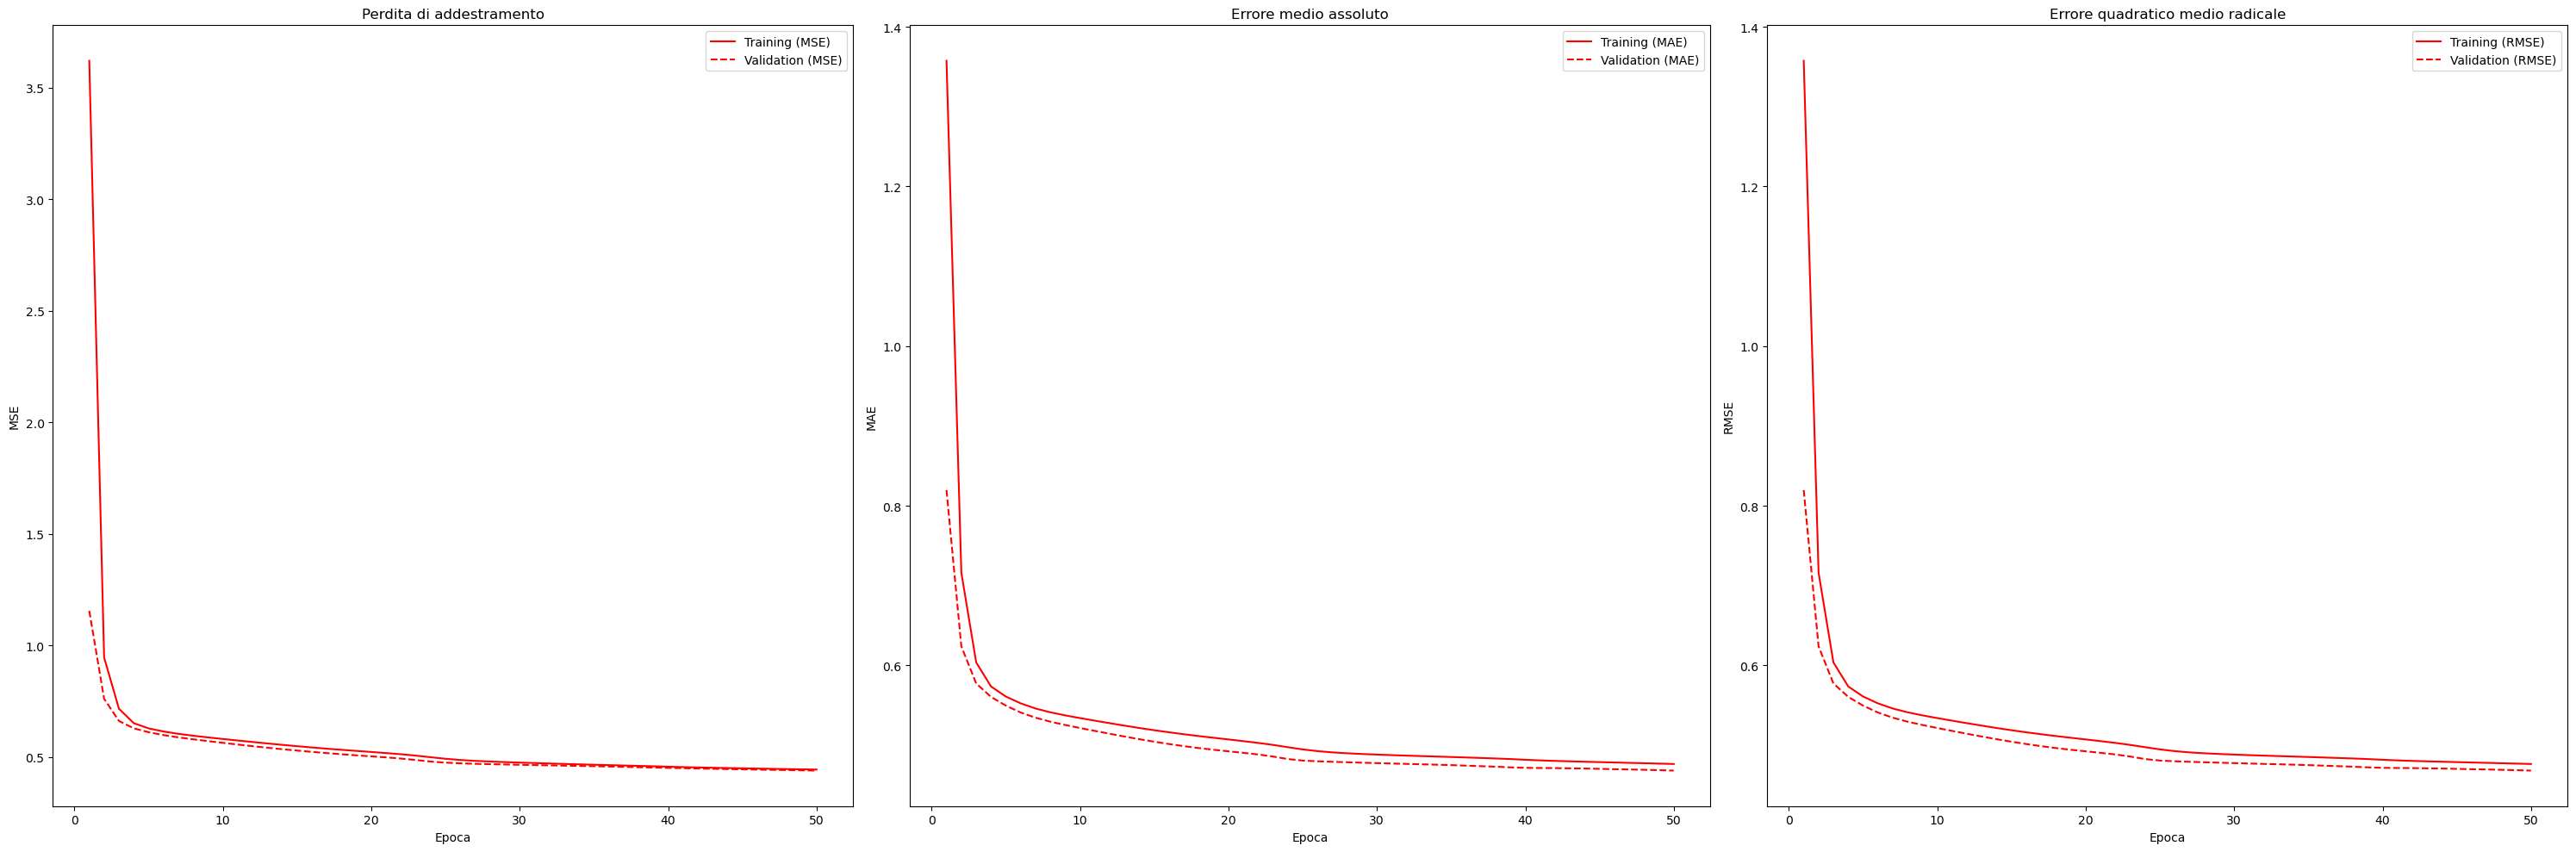

In [13]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' sia il risultato del tuo modello.fit()
loss = kan_history.history['loss']
val_loss = kan_history.history['val_loss']
mae = kan_history.history['mae']
val_mae = kan_history.history['val_mae']
rmse = kan_history.history['rmse']
val_rmse = kan_history.history['val_rmse']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'r', label='Training (MSE)') # linea rossa per training
plt.plot(epochs, val_loss, 'r--', label='Validation (MSE)') # linea tratteggiata rossa per validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, mae, 'r', label='Training (MAE)') # linea rossa per training
plt.plot(epochs, val_mae, 'r--', label='Validation (MAE)') # linea tratteggiata rossa per validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, rmse, 'r', label='Training (RMSE)') # linea rossa per training
plt.plot(epochs, val_rmse, 'r--', label='Validation (RMSE)') # linea tratteggiata rossa per validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


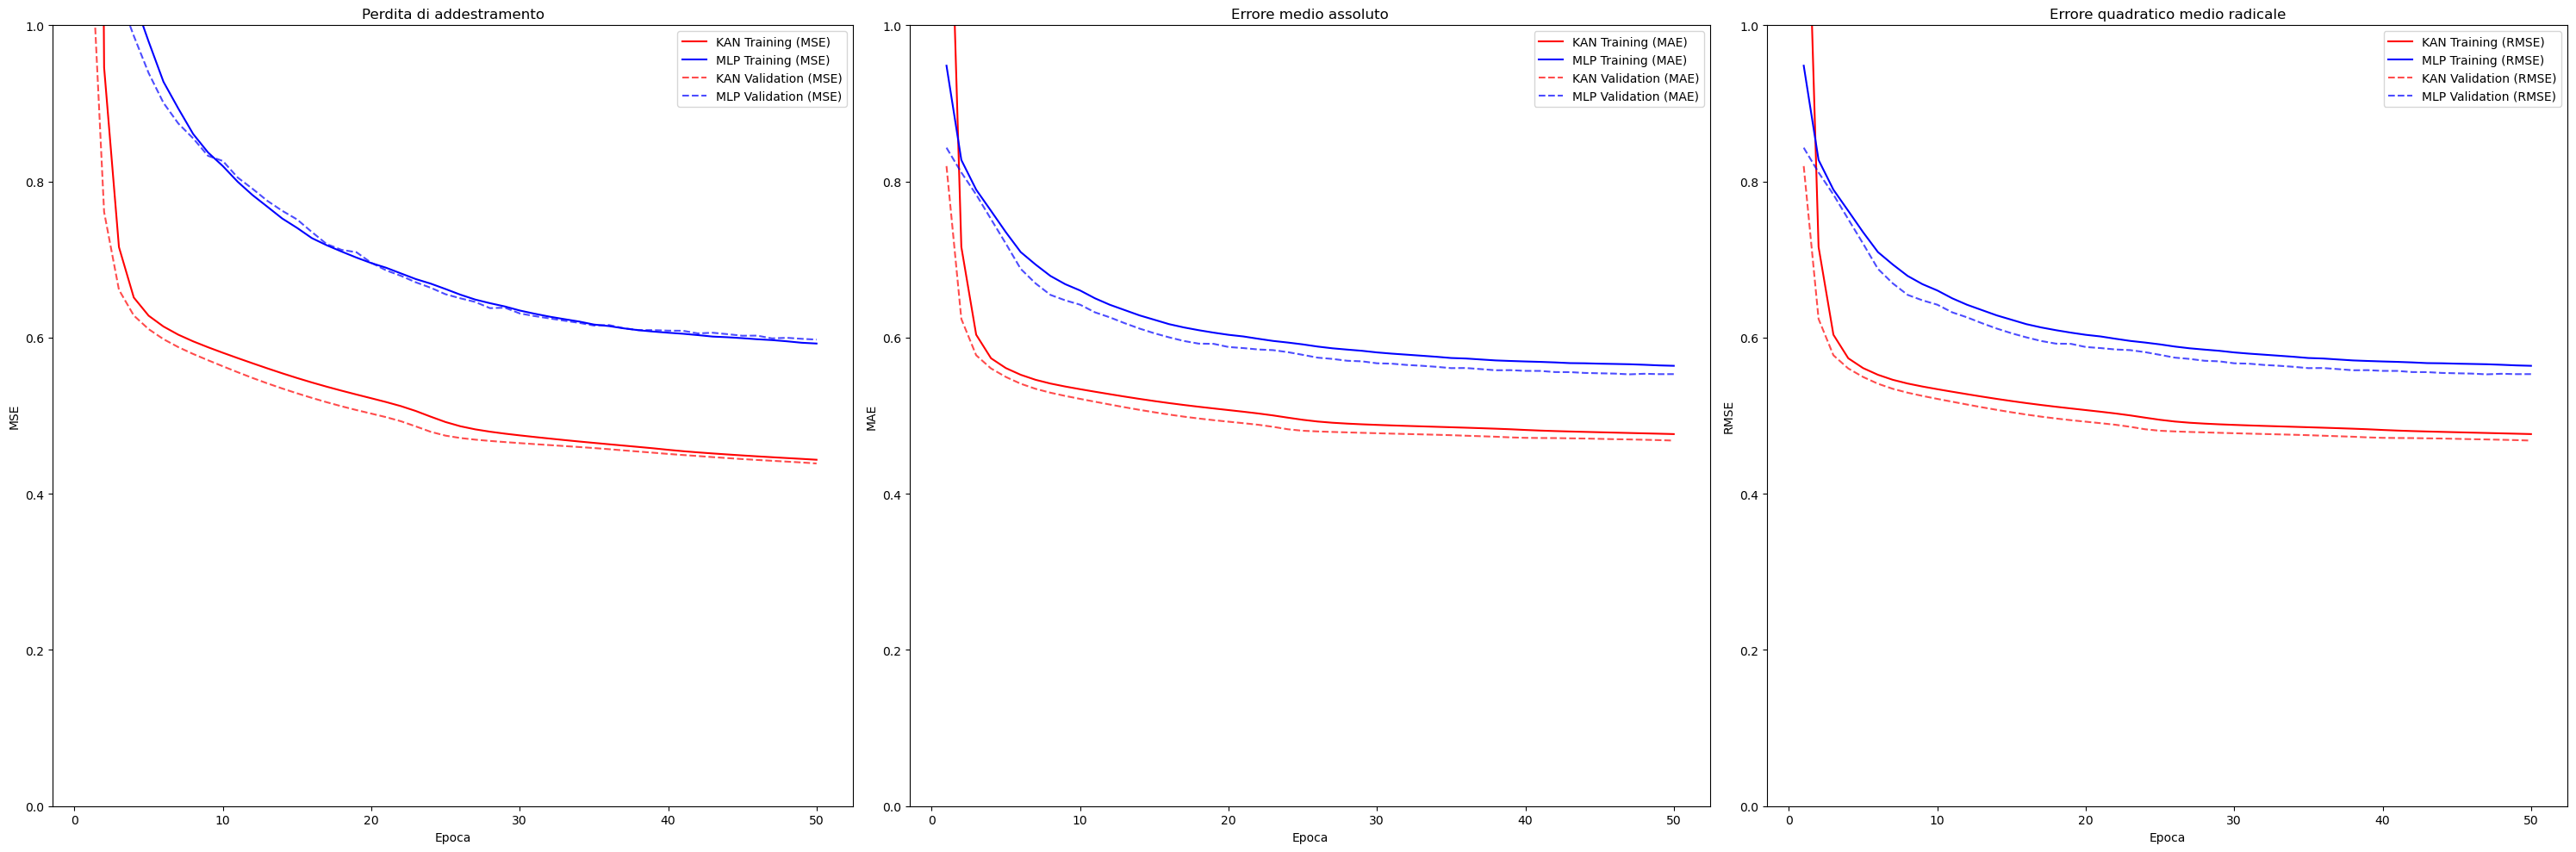

In [14]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' e 'mlp_history' siano i risultati del tuo modello.fit()
kan_loss = kan_history.history['loss']
kan_val_loss = kan_history.history['val_loss']
kan_mae = kan_history.history['mae']
kan_val_mae = kan_history.history['val_mae']
kan_rmse = kan_history.history['rmse']
kan_val_rmse = kan_history.history['val_rmse']

mlp_loss = mlp_history.history['loss']
mlp_val_loss = mlp_history.history['val_loss']
mlp_mae = mlp_history.history['mae']
mlp_val_mae = mlp_history.history['val_mae']
mlp_rmse = mlp_history.history['rmse']
mlp_val_rmse = mlp_history.history['val_rmse']

epochs = range(1, len(kan_loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, kan_loss, 'r', label='KAN Training (MSE)') # linea rossa per KAN
plt.plot(epochs, mlp_loss, 'b', label='MLP Training (MSE)') # linea blu per MLP
plt.plot(epochs, kan_val_loss, 'r--', alpha=0.7, label='KAN Validation (MSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_loss, 'b--', alpha=0.7, label='MLP Validation (MSE)') # linea tratteggiata blu per MLP validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, kan_mae, 'r', label='KAN Training (MAE)') # linea rossa per KAN
plt.plot(epochs, mlp_mae, 'b', label='MLP Training (MAE)') # linea blu per MLP
plt.plot(epochs, kan_val_mae, 'r--', alpha=0.7, label='KAN Validation (MAE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_mae, 'b--', alpha=0.7, label='MLP Validation (MAE)') # linea tratteggiata blu per MLP validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, kan_rmse, 'r', label='KAN Training (RMSE)') # linea rossa per KAN
plt.plot(epochs, mlp_rmse, 'b', label='MLP Training (RMSE)') # linea blu per MLP
plt.plot(epochs, kan_val_rmse, 'r--', alpha=0.7, label='KAN Validation (RMSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_rmse, 'b--', alpha=0.7, label='MLP Validation (RMSE)') # linea tratteggiata blu per MLP validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = kan.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    results[sg] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
                                                  0  \
MSE                                          0.4857   
MAE                                          0.4896   
RMSE  tf.Tensor(0.6969569, shape=(), dtype=float32)   

                                                   1  
MSE                                           0.4016  
MAE                                           0.4512  
RMSE  tf.Tensor(0.63369846, shape=(), dtype=float32)  


In [16]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
mlp_results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = mlp.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    mlp_results['Maschio' if sg == 0 else 'Femmina'] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
mlp_performance_df = pd.DataFrame(mlp_results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(mlp_performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
                                            Maschio  \
MSE                                          0.6550   
MAE                                          0.5781   
RMSE  tf.Tensor(0.8093457, shape=(), dtype=float32)   

                                             Femmina  
MSE                                           0.5518  
MAE                                           0.5335  
RMSE  tf.Tensor(0.74282867, shape=(), dtype=float32)  


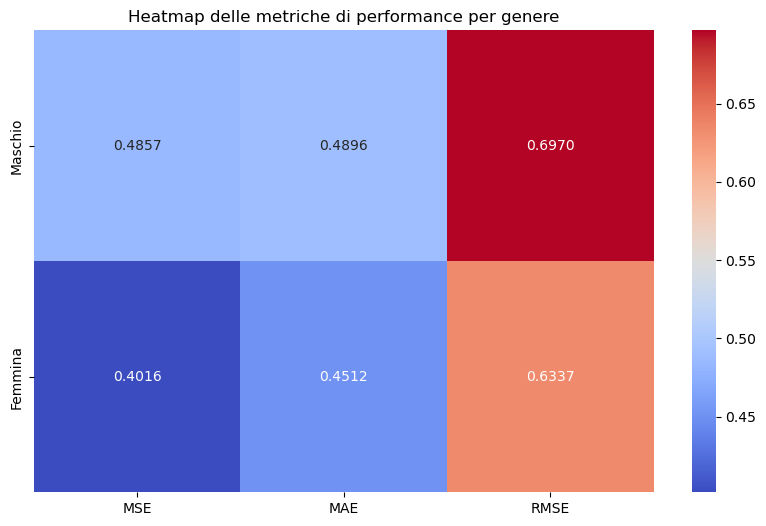

In [17]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
performance_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
performance_df = performance_df.astype(float)

# Trasposizione del DataFrame per avere le metriche come colonne e i valori di genere come righe
performance_df = performance_df.transpose()

# Creazione della heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere')
plt.show()


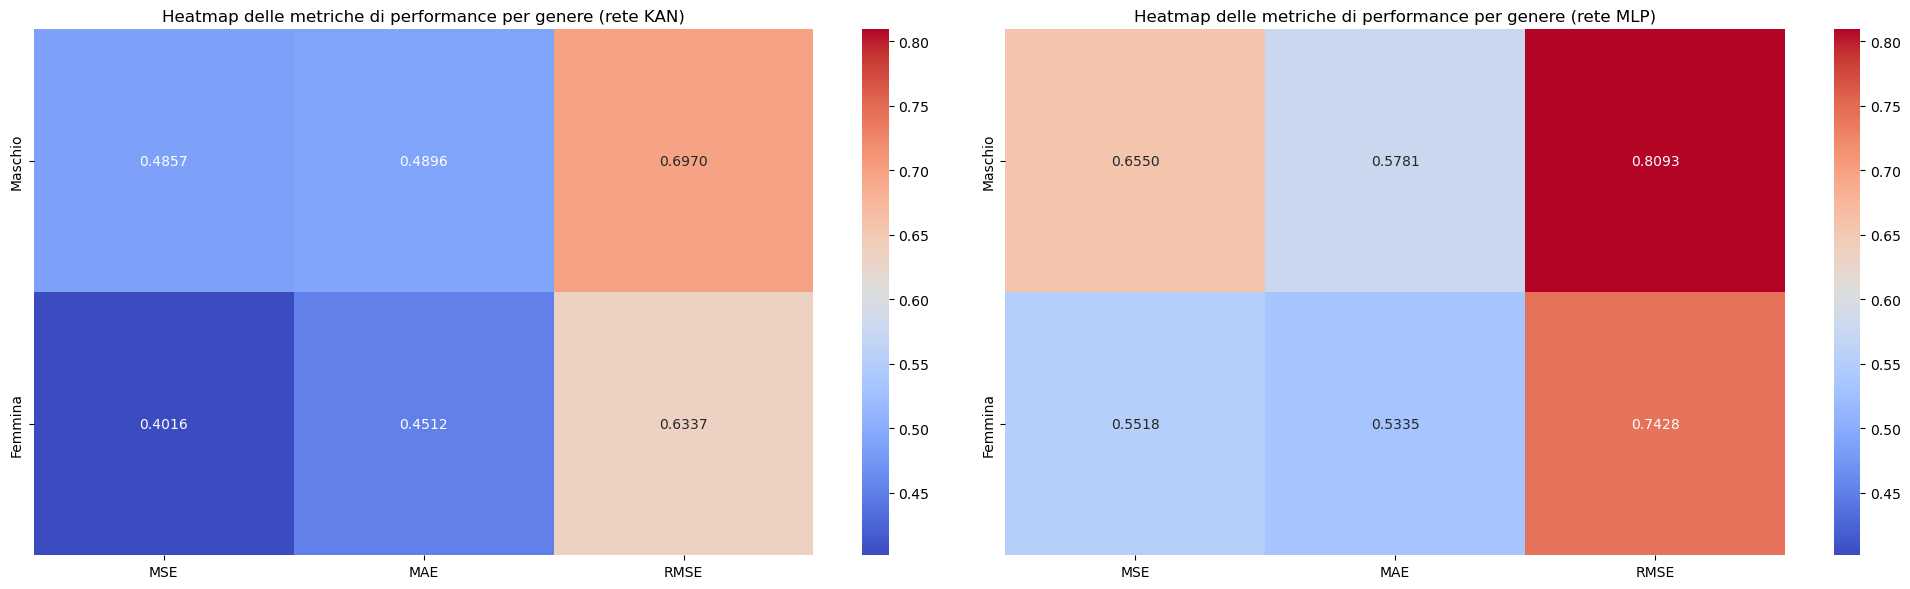

In [18]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance della rete KAN
kan_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
kan_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
kan_df = kan_df.astype(float)
mlp_performance_df = mlp_performance_df.astype(float)

# Trasposizione dei DataFrame per avere le metriche come colonne e i valori di genere come righe
kan_df = kan_df.transpose()
mlp_performance_df = mlp_performance_df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = min(kan_df.min().min(), mlp_performance_df.min().min())
vmax = max(kan_df.max().max(), mlp_performance_df.max().max())

# Creazione delle heatmap
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.heatmap(kan_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete KAN)')

plt.subplot(1, 2, 2)
sns.heatmap(mlp_performance_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete MLP)')

plt.tight_layout()
plt.show()


In [19]:
features = ['vdate', 'rcount', 'gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'discharged', 'facid']


In [20]:
# Lista delle caratteristiche
from sklearn.inspection import permutation_importance

def calculate_feature_importance(model, x_val, y_val):
    # Calcola l'importanza delle caratteristiche
    results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
    # Ottieni l'importanza delle caratteristiche
    importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance

# Calcola l'importanza delle caratteristiche per i modelli
mlp_importance = calculate_feature_importance(mlp, x_test, y_test)
kan_importance = calculate_feature_importance(kan, x_test, y_test)


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
469/469 ━━━

In [21]:
contatore_mlp = 0
contatore_kan = 0
importanza_mlp = {}
importanza_kan = {}

for feature, importance in mlp_importance.items():
    contatore_mlp += importance
    importanza_mlp[feature] = (importance)

for feature, importance in kan_importance.items():
    contatore_kan += importance
    importanza_kan[feature] = (importance)

print("Importanza delle caratteristiche per il modello MLP:")
for key in importanza_mlp.keys():
    importanza_mlp[key] = importanza_mlp[key] / contatore_mlp * 100
    print(f"feature: {key}, importanza: {round(importanza_mlp[key],3)}%")


print("\n\n\nImportanza delle caratteristiche per il modello KAN:")
for key in importanza_kan.keys():
    importanza_kan[key] = importanza_kan[key] / contatore_kan * 100
    print(f"feature: {key}, importanza: {round(importanza_kan[key], 3)}%")



Importanza delle caratteristiche per il modello MLP:
feature: vdate, importanza: 12.043%
feature: rcount, importanza: 51.708%
feature: gender, importanza: 0.007%
feature: dialysisrenalendstage, importanza: 0.785%
feature: asthma, importanza: 0.849%
feature: irondef, importanza: 1.63%
feature: pneum, importanza: 0.756%
feature: substancedependence, importanza: 1.205%
feature: psychologicaldisordermajor, importanza: 5.48%
feature: depress, importanza: 0.69%
feature: psychother, importanza: 0.822%
feature: fibrosisandother, importanza: 0.329%
feature: malnutrition, importanza: 0.728%
feature: hemo, importanza: 1.687%
feature: hematocrit, importanza: 1.635%
feature: neutrophils, importanza: 0.817%
feature: sodium, importanza: 1.12%
feature: glucose, importanza: 1.094%
feature: bloodureanitro, importanza: 0.317%
feature: creatinine, importanza: 1.042%
feature: bmi, importanza: 1.073%
feature: pulse, importanza: 1.052%
feature: respiration, importanza: 1.16%
feature: secondarydiagnosisnonicd

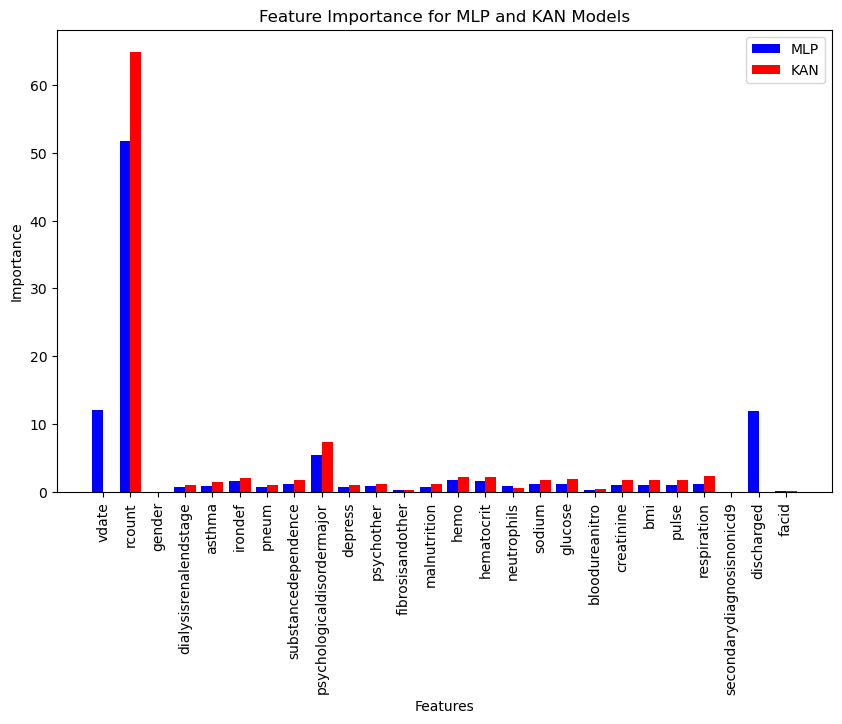

In [22]:

# Crea le etichette per l'asse x
x = np.arange(len(importanza_mlp.values()))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(10, 6))  # Modifica le dimensioni qui

# Crea le barre per l'importanza delle caratteristiche del modello MLP
bar1 = ax.bar(x - 0.2, list(importanza_mlp.values()), 0.4, label='MLP', color='blue')

# Crea le barre per l'importanza delle caratteristiche del modello KAN
bar2 = ax.bar(x + 0.2, list(importanza_kan.values()), 0.4, label='KAN', color='red')

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for MLP and KAN Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)
ax.legend()

# Mostra il grafico
plt.show()

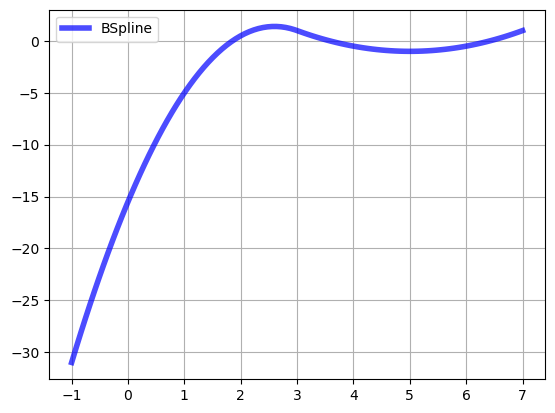

In [53]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

# Definisci i punti di controllo
k = 2
t = [0, 1, 2, 3, 4, 5, 6]
c = [-1, 2, 0, -1]
spl = BSpline(t, c, k)

# Estendi il range sull'asse x per visualizzare la spline su un intervallo più grande
fig, ax = plt.subplots()
xx = np.linspace(-1, 7, 100)  # Modifica il range qui per visualizzare la spline su un intervallo più grande
ax.plot(xx, spl(xx), 'b-', lw=4, alpha=0.7, label='BSpline')
ax.grid(True)
ax.legend(loc='best')
plt.show()

# Esempio di come creare una collezione di B-spline per il tuo scopo
spline_collection = [spl for _ in range(20)]

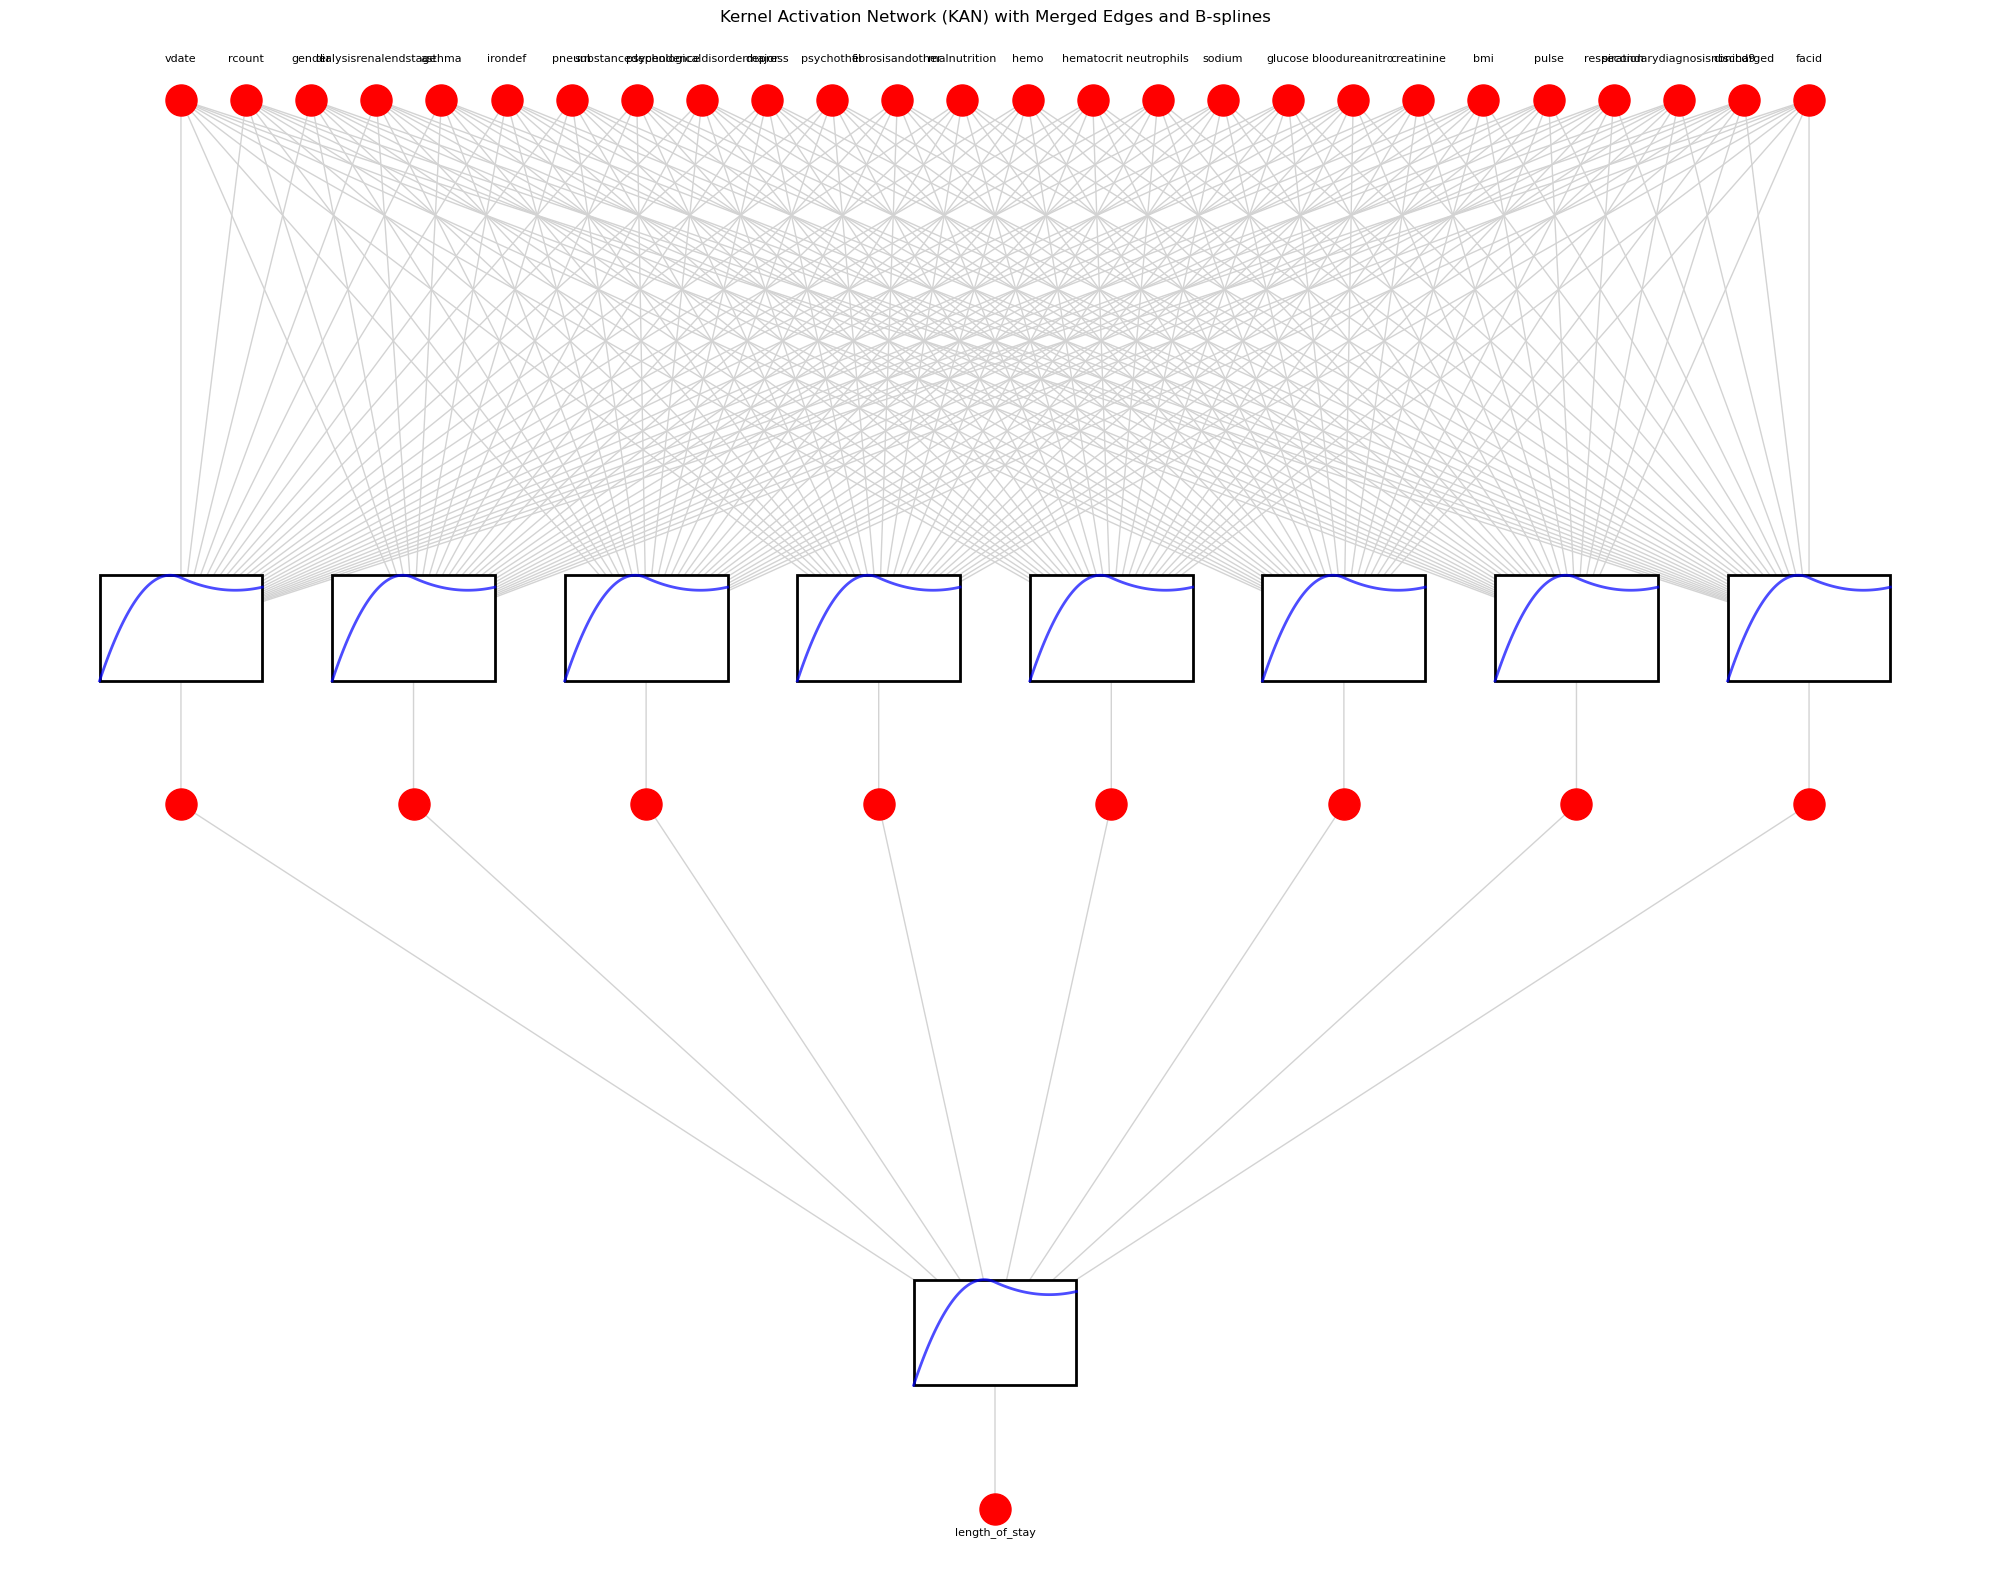

In [54]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline

def create_kan_tree_from_model(model, features):
    G = nx.DiGraph()
    
    # Aggiungi nodi di input
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Aggiungi livelli nascosti e livello di output dal modello
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        # Connetti al livello precedente
        if layer_idx == 0:
            prev_layer_units = len(features)
        else:
            prev_layer_units = model.layers[layer_idx-1].units
        
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    return G

def draw_merged_edges(G, pos, ax, sline_collection, edge_color='lightgray'):
    merge_points = []
    for target in G.nodes():
        in_edges = G.in_edges(target)
        if len(in_edges) > 1:
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[list(in_edges)[0][0]][1] - target_pos[1]) / 4])
            merge_points.append(merge_point)
            
            for source, _ in in_edges:
                start = np.array(pos[source])
                
                ax.annotate("", xy=merge_point, xytext=start,
                            arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"),
                            zorder=1)
            
            ax.annotate("", xy=target_pos, xytext=merge_point,
                        arrowprops=dict(arrowstyle="-", color=edge_color),
                        zorder=1)
    
    # Disegna quadrati ai punti di fusione e B-spline all'interno
    square_size = 0.1  # Dimensione fissa del quadrato
    for i, point in enumerate(merge_points):
        if i < len(sline_collection):
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2,
                                   fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Disegna la B-spline all'interno del quadrato
            spl = sline_collection[i]
            xx = np.linspace(spl.t[0], spl.t[-1], 100)
            yy = spl(xx)
            
            # Calcola il range della spline
            x_range = np.max(xx) - np.min(xx)
            y_range = np.max(yy) - np.min(yy)
            
            # Normalizza i valori della B-spline per adattarli al quadrato
            xx_norm = (xx - np.min(xx)) / x_range * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / y_range * (square_size / 2) + (point[1] - square_size / 4)
            
            ax.plot(xx_norm, yy_norm, 'b-', lw=2, alpha=0.7, zorder=3)

    return merge_points


# Crea il grafo dal modello
G = create_kan_tree_from_model(kan, features)

# Imposta il plot
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')


# Disegna gli archi e i quadrati con le B-spline
merge_points = draw_merged_edges(G, pos, ax, spline_collection)

# Disegna i nodi sopra gli archi
node_collection = nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red', ax=ax)
node_collection.set_zorder(4)  # Imposta zorder per i nodi

# Aggiungi etichette
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)
for text in label_collection.values():
    text.set_zorder(5)  # Imposta zorder per le etichette

# Aggiungi l'etichetta "length_of_stay" sotto il nodo più basso
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
lowest_node_x, lowest_node_y = pos[lowest_node]
length_of_stay_text = ax.text(lowest_node_x, lowest_node_y - 0.012, "length_of_stay", fontsize=8, ha='center')
length_of_stay_text.set_zorder(5)  # Imposta zorder per l'etichetta length_of_stay

plt.title("Kernel Activation Network (KAN) with Merged Edges and B-splines")
plt.axis('off')
plt.tight_layout()

plt.show()


In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error


# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(max_depth= 5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
tree.fit(x1_train, y1_train)

# Fai delle previsioni sul set di test
y_pred = tree.predict(x1_test)

# Poiché desideri una previsione finale come numero intero positivo, arrotonda le previsioni all'intero più vicino
y_pred = np.round(y_pred).clip(min=0)

# Calcola l'errore quadratico medio
mse = mean_squared_error(y1_test, y_pred)
mae = mean_absolute_error(y1_test, y_pred)
rmse = root_mean_squared_error(y1_test, y_pred)
print(f'Mean Squared Error: {mse}, Mean absolute error: {mae}, Root mean squared error: {rmse}')


Mean Squared Error: 1.6482666666666668, Mean absolute error: 0.948, Root mean squared error: 1.2838483814947412


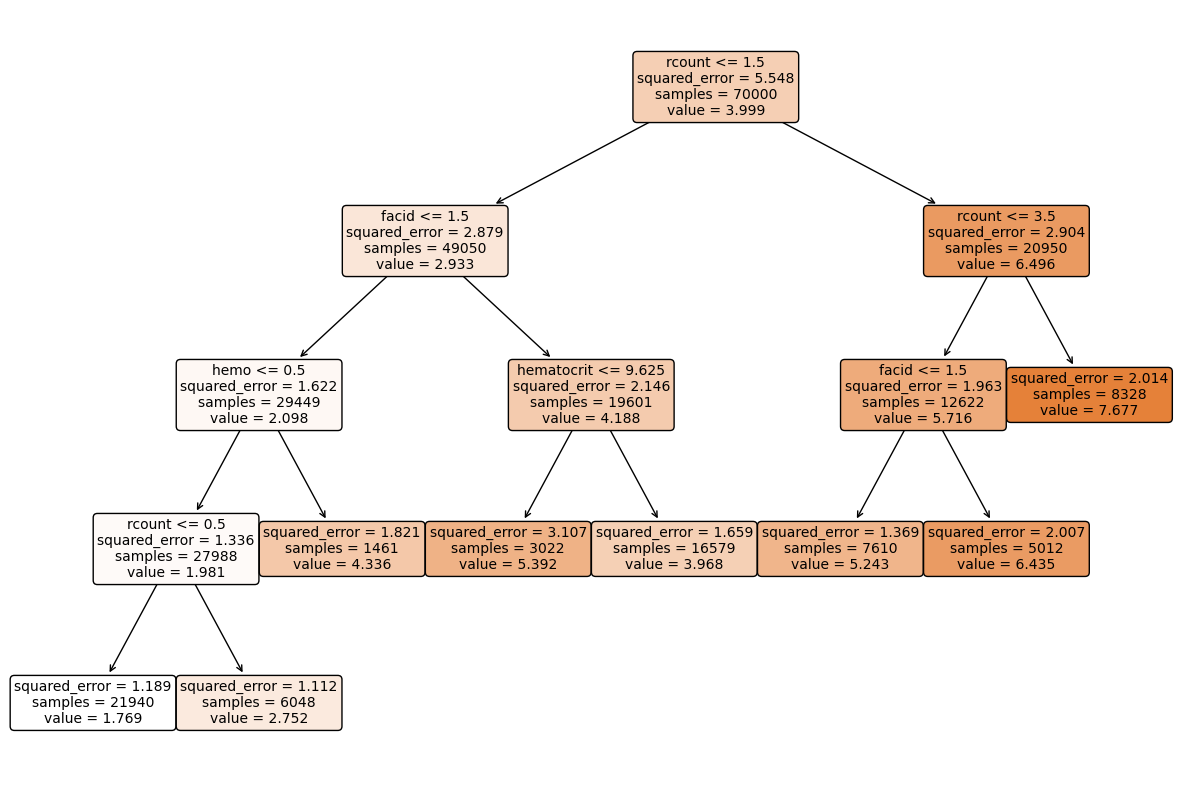

In [49]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Crea una figura
plt.figure(figsize=(15,10))

# Disegna l'albero
plot_tree(tree, max_depth=5, filled=True, rounded=True, feature_names=features)

# Mostra il plot
plt.show()


In [71]:
# # Funzione per costruire i modelli

# def build_model(nodes: list, loss: str='mse', optimizer: str='adam', metrics: list=['accuracy'], mlp: bool=False, kan: bool=False):
#     assert not (mlp and kan)
#     n_levels = len(nodes)
#     model = tf.keras.Sequential()

#     levels = []
#     if mlp:
#         model.add(tf.keras.layers.Dense(nodes[0]))
#         for layer in range(1, n_levels):
#             model.add(tf.keras.layers.Dense(nodes[layer]))
#     else:
#         model.add(tf.keras.layers.Dense(nodes[0]))
#         for layer in range(1, n_levels):
#             model.add(DenseKAN(nodes[layer]))

#     model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#     print(levels)
#     return model

# from keras.models import Sequential
# from keras.layers import Dense

def build_model(nodes: list, input_dim: int, loss: str='mse', optimizer: str='adam', metrics: list=['accuracy'], mlp: bool=True):
    model = tf.keras.Sequential()
    numero_livelli = len(nodes)

    if mlp:
        model.add(tf.keras.layers.Input(shape=(input_dim,)))
        for i in range(0, numero_livelli):
            model.add(tf.keras.layers.Dense(nodes[i], activation='relu'))
    else:
        model.add(tf.keras.layers.Input(shape=(input_dim,)))
        for i in range(0, numero_livelli):
            model.add(DenseKAN(nodes[i]))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


In [72]:
input_dim = 26
nodes = [4,3,1]
nodes_kan = [3,1]

mlp_model = build_model(nodes, input_dim, mlp=True)
mlp_model.summary()

# kan_model = build_model(nodes_kan, input_dim, mlp=False)
# kan_model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 4)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127 (508.00 B)

 Trainable params: 127 (508.00 B)

 Non-trainable params: 0 (0.00 B)